## Topic Fingerprints

In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', 800)

In [2]:
OPEN_DATA_URL = 'data/canada-open-data/inventory.csv'
COLUMNS = ['title_en', 'description_en','date_released']
catalog = pd.read_csv(OPEN_DATA_URL, usecols=COLUMNS)
catalog = catalog.dropna(subset=['description_en'])

In [3]:
catalog

,title_en,description_en,date_released
0,The AAFC Productivity Account for Canadian Agriculture,"The AAFC Productivity Account for Canadian agriculture is an annual time-series database, covering the years 1961-2011, that is comprised of price index and constant dollar implicit quantity series for gross output and input aggregates. The data are defined at the national level only – i.e. for the whole of Canada. These data are used to estimate a total factor productivity (TFP) index for Canadian agriculture, which is the ratio of total gross output to total input, where both output and input are constant dollar implicit quantities. Average growth in the TFP index, referred to as TFP growth, can be estimated using a variety of methods; the growth rate reported in AAFC publications is estimated using OLS.\r\n\r\nFurther documentation provided in AAFC_PACA.odt",2018-08-10
1,Swift Current Water Chemistry - Long Term Tillage Study - 1962-2011,"The Swift current water quantity and quality is an annual time-series database covering the period of 1962-2011. This database contains datasets for annual runoff volume, peak flow rates, water quality attributes, snow water equivalent and soil moisture from an edge of field study conducted at Swift Current, SK.",2018-11-23
2,Minor Use Pesticides Program Project Status by Crop,"The Pest Management Centre’s (PMC) Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\r\n\r\nThis is a complete list of PMC’s projects with their statuses. For those projects with the status D.3.2 Review Complete, please check with the p...",2018-12-14
3,Minor Use Pesticides Program Submission Status by Fiscal Year,"The Pest Management Centre Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\r\n\r\nThis list of submissions to PMRA is the result of PMC’s work and is for information purposes only. To find out if the pesticide can be used, please chec...",2018-12-14
4,Minor Use Pesticides Program Trial Statistics by Year by Discipline,The following table provides information pertaining to the minor use pesticide study and/or trial status. These studies/trials are managed by the Pest management Center of the AAFC. This table is updated monthly.,2018-12-14
5,"Land Cover for Agricultural Regions of Canada, circa 2000","The “Land Cover for Agricultural Regions of Canada, circa 2000” is a thematic land cover classification representative of Circa 2000 conditions for agricultural regions of Canada. Land cover is derived from Landsat5-TM and/or 7-ETM+ multi-spectral imagery by inputting imagery and ground reference training data into a Decision-Tree or Supervised image classification process. Object segmentation, pixel filtering, and/or post editing is applied as part of the image classification. Mapping is corrected to the GeoBase Data Alignment Layer. National Road Network (1:50,000) features and other select existing land cover pr

In [4]:
%autosave 60

Autosaving every 60 seconds


In [5]:
def text_to_tokens(text):
    text = text.lower()
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    return tokens

In [6]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess

dataset_descriptions = catalog.description_en.apply(text_to_tokens)

C:\Users\dwight\Anaconda3\envs\packt\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
dataset_descriptions

0                                                                                                                                                                                                         [aafc, productivity, account, canadian, agriculture, annual, time, series, database, covering, years, comprised, price, index, constant, dollar, implicit, quantity, series, gross, output, input, aggregates, data, defined, national, level, canada, data, estimate, total, factor, productivity, tfp, index, canadian, agriculture, ratio, total, gross, output, total, input, output, input, constant, dollar, implicit, quantities, average, growth, tfp, index, referred, tfp, growth, estimated, variety, methods, growth, rate, reported, aafc, publications, estimated, ols, documentation, provided, aafc_paca, odt]
1                                                                                                                                                                                              

In [8]:
import gensim
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string

dictionary = gensim.corpora.Dictionary(dataset_descriptions)
corpus = [dictionary.doc2bow(text) for text in dataset_descriptions]

## Dictionary

In [9]:
for i in range(0, 20):
    print(i, dictionary[i])

0 aafc
1 aafc_paca
2 account
3 aggregates
4 agriculture
5 annual
6 average
7 canada
8 canadian
9 comprised
10 constant
11 covering
12 data
13 database
14 defined
15 documentation
16 dollar
17 estimate
18 estimated
19 factor


## Corpus

In [10]:
VECTOR_SIZE=50
lda_model:LdaModel = LdaModel(corpus, 
                              num_topics=VECTOR_SIZE, 
                              passes=4)
lda_model.num_topics

50

In [11]:
text = catalog.description_en[0]
tokens = text_to_tokens(text)
bag_of_words = dictionary.doc2bow(tokens)
pd.DataFrame(lda_model[bag_of_words], 
             columns=['Topic','Relevance']).set_index('Topic')

,Relevance
Topic,
7,0.092989
11,0.440349
12,0.025840
13,0.043294
16,0.121448
17,0.028735
22,0.077757
23,0.031018
34,0.014366


In [12]:
def topic_vector(topic_model:LdaModel, text:str):
    processed_text = text_to_tokens(text)
    bag_of_words = dictionary.doc2bow(processed_text)
    fingerprint = [0] * topic_model.num_topics
    for topic, prob in topic_model[bag_of_words]:
        fingerprint[topic] = prob
    return fingerprint

In [18]:
import matplotlib.pyplot as plt
import matplotlib.style as style
from IPython.display import display

style.use('fivethirtyeight')

VECTOR_SIZE=50
%matplotlib inline

def show_fingerprint(topic_model, text:str):
    display(text)
    vector = topic_vector(topic_model, text)
    plt.figure(figsize=(14,2))
    ax = plt.bar( range(len(vector)), 
                 vector, 
                 0.25, 
                 linewidth=1)
    plt.ylim(top=0.4)
    plt.tick_params(axis='both', 
                    which='both',
                    left=False, 
                    bottom=False, 
                    top=False,
                    labelleft=False, 
                    labelbottom=False)
    plt.grid(False)

'The AAFC Productivity Account for Canadian agriculture is an annual time-series database, covering the years 1961-2011, that is comprised of price index and constant dollar implicit quantity series for gross output and input aggregates. The data are defined at the national level only – i.e. for the whole of Canada. These data are used to estimate a total factor productivity (TFP) index for Canadian agriculture, which is the ratio of total gross output to total input, where both output and input are constant dollar implicit quantities. Average growth in the TFP index, referred to as TFP growth, can be estimated using a variety of methods; the growth rate reported in AAFC publications is estimated using OLS.\r\n\r\nFurther documentation provided in AAFC_PACA.odt'

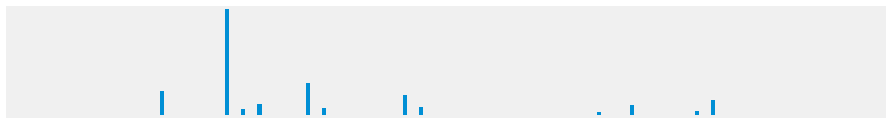

In [19]:
show_fingerprint(lda_model, catalog.description_en[0])

"The Pest Management Centre Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\r\n\r\nThis list of submissions to PMRA is the result of PMC’s work and is for information purposes only. To find out if the pesticide can be used, please check with the pesticide manufacturer or visit PMRA's pesticide label database. "

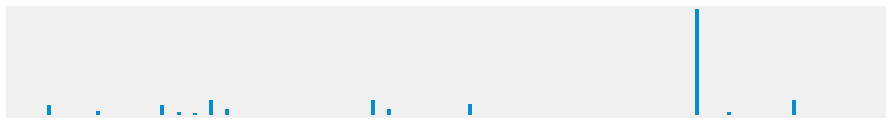

In [20]:
show_fingerprint(lda_model, catalog.description_en[3])

"The Pest Management Centre’s (PMC) Minor Use Pesticides Program is a joint initiative between Agriculture and Agri-Food Canada and Health Canada’s Pest Management Regulatory Agency (PMRA) to improve the availability of reduced-risk products to agricultural producers and improve the access to a broad range of minor use pesticides. The PMC reviews the data resulting from field trials and laboratory analyses, and prepares a submission to PMRA to support the registration of the minor use pesticide. Upon receiving a finalized regulatory submission from PMC, PMRA reviews it and decides whether or not to accept the pesticide for use in Canada.\r\n\r\nThis is a complete list of PMC’s projects with their statuses. For those projects with the status D.3.2 Review Complete, please check with the pesticide manufacturer or visit PMRA's pesticide label database to find out if the pesticide is ready for use. "

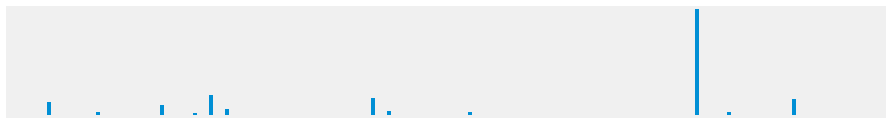

In [21]:
show_fingerprint(lda_model, catalog.description_en[2])

In [17]:
topic_vector(lda_model, catalog.description_en[0])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.09299018,
 0,
 0,
 0,
 0.44035187,
 0.025838073,
 0.043303043,
 0,
 0,
 0.121443294,
 0.028735016,
 0,
 0,
 0,
 0,
 0.077753425,
 0.03101858,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0143661965,
 0,
 0.03848558,
 0,
 0,
 0,
 0.01814198,
 0.056868568,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]